<a href="https://colab.research.google.com/github/SherbyRobotics/pyro/blob/colab/examples/notebooks/2DoF_robot_arm_impedance_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot arm impedance control

This page introduce the concept of controlling a robot arm position by adding virtual spring (i.e. what we can call impedance control) in both the joint-space (angles) and the task-space (x,y,z).

In this homework we will:

1.   Load an object describing the two-link arm behavior;
2.   Add virtual angular springs on the joint (joint-space impedance control);
3.   Add virtual linear springs on the end-effector (task-space impedance control);
4.   Try to improve the controller with your custom solution;

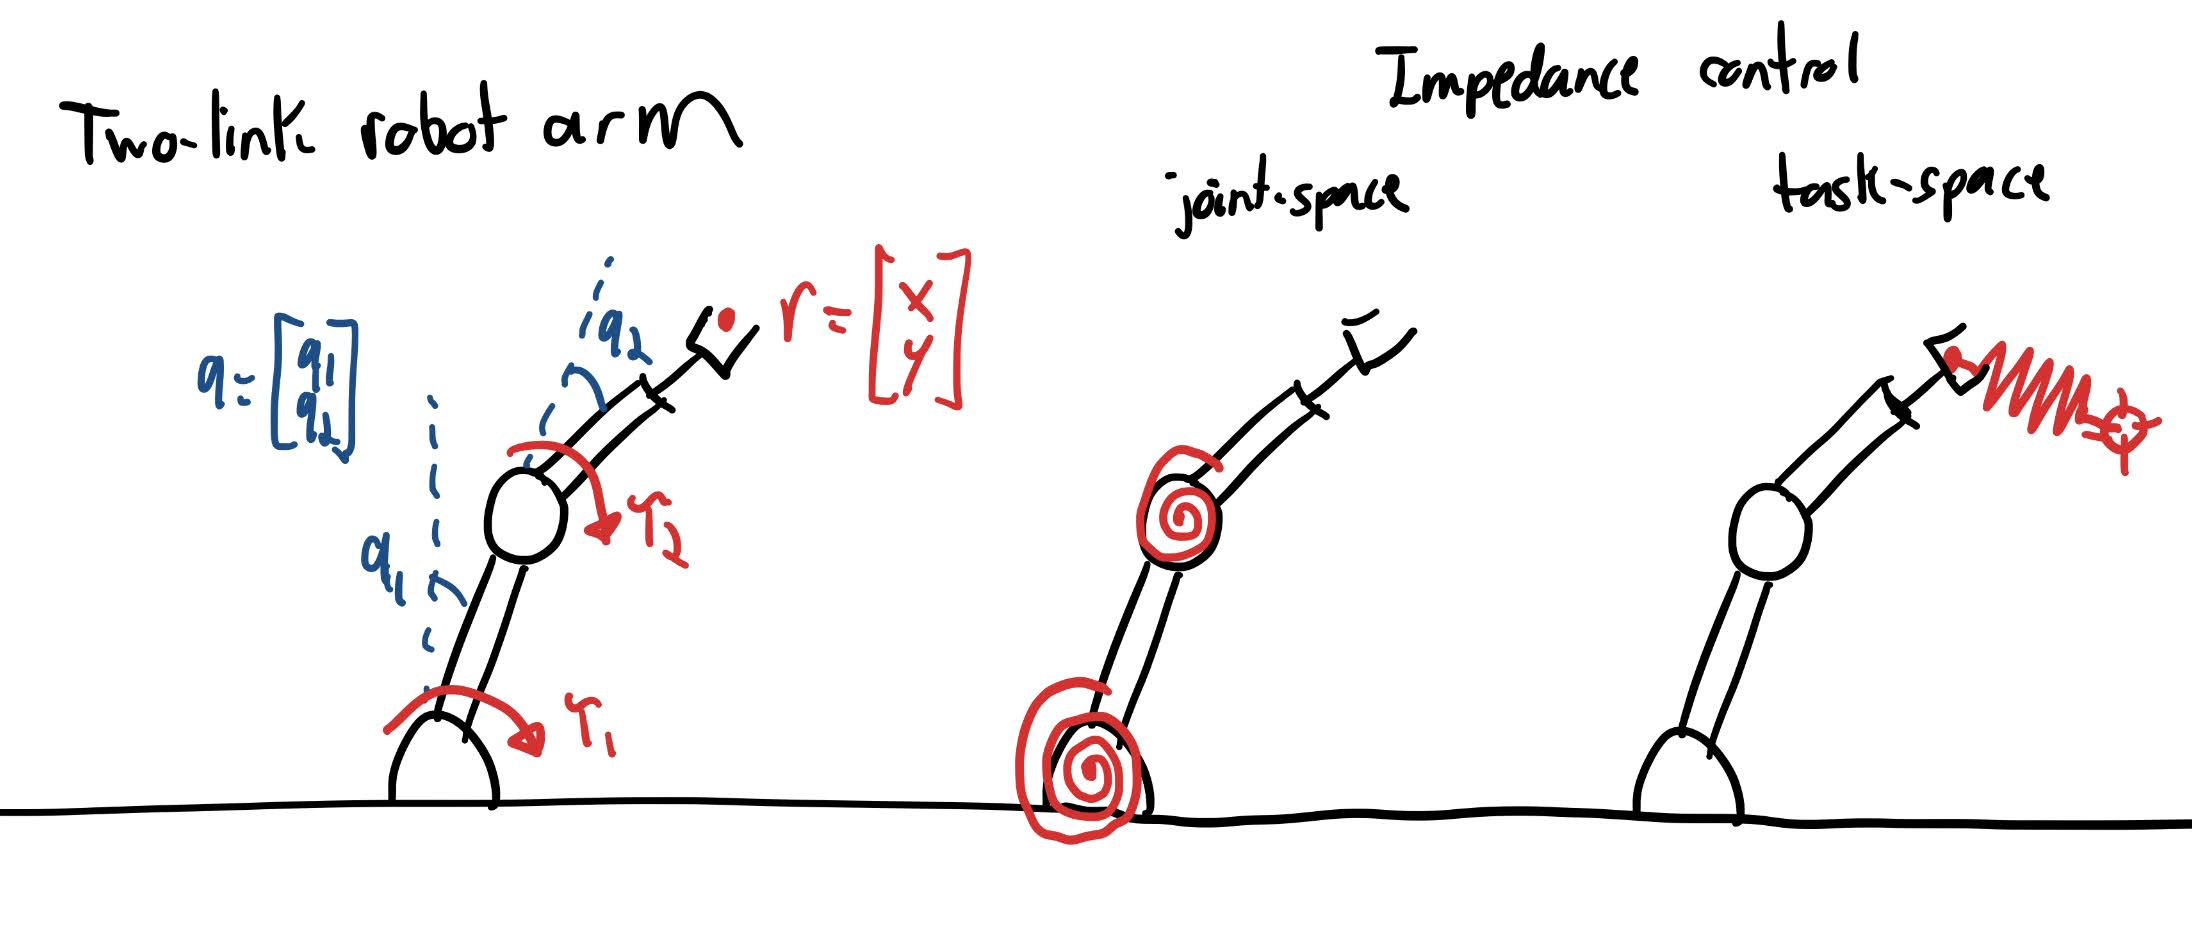

## Importing Librairies

In [ ]:
# Loading a robotic toolbox
!git clone https://github.com/SherbyRobotics/pyro
import sys
sys.path.append('/content/pyro')
import pyro

# Generic python tools
import numpy as np
from IPython import display

# Defining the robot arm

Here we load a already defined class from the library including the dynamic equations defining the robot arm behavior, which is a function of the form:

$H(q)\ddot{q} + C(\dot{q},q)\dot{q} + d(\dot{q},q) + g(q) = B \tau $

where $q$ is a 2x1 column vector of the joint angular position and $\tau$ is a 2x1 column vector of motor torque.

*   $H(q)$ is an inertia matrix
*   $C(\dot{q},q)$ is a matrix caracterizing coriolis and centrifugal effects
*   $d(\dot{q},q)$ is a vector describing the state-dependent dissipative forces
*   $g(q)$ is a vector describing the state-dependent dissipative forces
*   $B$ is a matrix describing how the actuator act on the system



In [ ]:
from pyro.dynamic import manipulator

robot = manipulator.TwoLinkManipulator()

The properties like the lenght of the two links can be modified here:

In [ ]:
robot.l1 = 0.5 # length of first rigid link
robot.l2 = 0.3 # length of second rigid link

## Showing the robot natural behavior with no controllers

Here we run a simulation of the robot arm with no controllers:

In [ ]:
# robot initial states [ joint 1 angle (rad),  joint 2 angle (rad), joint 1 velocity (rad/sec),  joint 1 velocity (rad/sec)]
robot.x0 = np.array([ 0.1, 0.1, 0.0, 0.0]) 

# run the simulation
robot.compute_trajectory( tf = 6 )

# Animate and display the simulation
ani  = robot.generate_simulation_html_video()
html = display.HTML( ani )
display.display(html)

# Joint-space impedance control

First lets try to put simple independent joint-controller where the torque is proportionnal to the joint position error and the joint velocity. This is basically equivalent to independent proportionnal-derivative controller on each joint:

$\tau = K_p \left(q_{d} - q\right) + 
K_d \left(- \dot{q}\right)$

Physically the effect of this controller is equivalent to add angular spring and damper on each joint of the robot that have equilibrium points on the desired joint position. Let try to control the two-link robot with this approach. Here we first defined a controller object that implement this control law and set the desire parameter:

In [ ]:
from pyro.control  import robotcontrollers

# Target
q_desired = np.array([0.5,0.5]) # this set the desired joint angles vector

# Joint PID
joint_pd      = robotcontrollers.JointPD( dof = 2 )
joint_pd.rbar = q_desired
joint_pd.kp   = np.array([5, 5 ]) # This set the diagonal values of the Kp matrix
joint_pd.kd   = np.array([ 0, 0 ]) # This set the diagonal values of the Kd matrix

In [ ]:
# This shows the commanded torque as a function of the configuration (at zero velocity)
#joint_pd.plot_control_law( sys = robot , n = 100 )

## Simulating the robot in closed-loop

Here we run a simulation of the robot with the joint-impedance controller.

In [ ]:
# Create the closed-loop system
robot_with_joint_pd = joint_pd + robot

# robot initial states [ joint 1 angle (rad),  joint 2 angle (rad), joint 1 velocity (rad/sec),  joint 1 velocity (rad/sec)]
#closed_loop_robot.x0 = np.array([0.1,0.1,0,0])  

# Run the simulation
robot_with_joint_pd.compute_trajectory( tf = 5 )

In [ ]:
# Animate the simulation
ani = robot_with_joint_pd.generate_simulation_html_video()
html = display.HTML(ani)
display.display(html)

In [ ]:
# Plot systems states
robot_with_joint_pd.plot_trajectory('x')

In [ ]:
# Plot control inputs
robot_with_joint_pd.plot_trajectory('u')

## Analyzing the results

Does this controller give a satisfactory behavior? Try go back and update the controller parameters ($Kp$ and $Kd$) to improve the results. Pay attention the the following performance indicator:

1.   How fast does the robot reach the target position?
2.   How much torque are required?
3.   Is there a large final error after the system stabilize?
4.   Is there a big overshoot and large oscillations?




### Frequency domain point of view

The following plot shows the frequency response of the closed-loop for the first joint, where we can also look at the bandwidth and the presence (or not) of a resonance.

In [ ]:
robot_with_joint_pd.plot_linearized_bode()

# Task-space impedance controller

Here we will repeat the process but with a task-space impedance controller. The idea is similar but here we want a controller that will have the effect of attaching a linear spring between the end-effector and the target. 

This controller will required the knowledge of robot kinematic equations defining the relationship between the end-effector position (column vector $r$) and the joint position, i.e. a forward kinematic function of the form $r = f(q)$ and a differential kinematic function of the form $\dot{r} = J(q) \dot{q}$.

The controller equation we implement to do this is:

$\tau = J(q)^T \left[ K_p \left(r_{d} - f(q)\right) + 
K_d \left(- J(q) \dot{q}\right) \right]$

This equation first compute the cartesien error at the effector, mulitply it by a gain matrix represeting linear stiffness and then convert this desired linear force in equavalent motor torques by multiplying the linear force vector by the transpose of the Jacobian matrix. The theoretical background regarding this approach is summarised in the following videos:

In [ ]:
display.IFrame("https://www.youtube.com/embed/videoseries?list=PL6adNeJ0A8UtKTsdDwfei6sKDKJt25ZBO",600,450)

Here we load a controller class implementing this end-effector impedance control law. We will set the desired position of the end-effector $r_d$ to be equivalent to the previously used target joint position.

In [ ]:
# End-effector desired position 
r_desired = robot.forward_kinematic_effector( q_desired )
print('Target joint angles [q_1,q_2] =', q_desired )
print('Target effector [x,y] =', r_desired )

effector_pd      = robotcontrollers.EndEffectorPD( robot )
effector_pd.rbar = r_desired
effector_pd.kp   = np.array([100, 100 ]) # This set the diagonal values of the Kp matrix
effector_pd.kd   = np.array([  0,   0 ]) # This set the diagonal values of the Kd matrix

In [ ]:
# This shows graphically the computed torque for joint 1 as a function of the configuration
effector_pd.plot_control_law( sys = robot , n = 100 )

In [ ]:
# Create the closed-loop system
robot_with_effector_pd = effector_pd + robot

# robot initial states [ joint 1 angle (rad),  joint 2 angle (rad), joint 1 velocity (rad/sec),  joint 1 velocity (rad/sec) ]
#closed_loop_robot.x0 = np.array([0.1,0.1,0,0,0,0])  

# Run the simulation
robot_with_effector_pd.compute_trajectory( tf = 5 )

In [ ]:
# Animate the simulation
ani = robot_with_effector_pd.generate_simulation_html_video()
html = display.HTML(ani)
display.display(html)

In [ ]:
robot_with_effector_pd.plot_trajectory('x')

In [ ]:
robot_with_effector_pd.plot_trajectory('u')

## Analyzing the results

Does this controller give a satisfactory behavior? Try go back and update the controller parameters ($Kp$ and $Kd$) to improve the results. Pay attention the the following performance indicator:

1.   How fast does the robot reach the target position?
2.   How much torque are required?
3.   Is there a large final error after the system stabilize?
4.   Is there a big overshoot and large oscillations?

Do you think the task-space impedance controller is an improvement over the joint-space impedance controller?

Try to also changing the initial condition (see robot.x0 at the begining) and the target position.

# Custom controller

Now instead of simply trying to tune the parameters of a given control law, lets go free style. Here bellow you can write your own custom robot control law. Here the framework is already set in place for you to speed-up the implementation process. The following variable are pre-computed and available for you to use in the feedback law:

*   The joint angles $q$ 
*   The joint velocities $\dot{q}$ 
*   The desired end-effector position $r_d$

Furthermore, based on a robot model the following properties are also pre-computed:
*   The actual end-effector position $r$
*   The Jacobian $J(q)$
*   The gravity vector $g(q)$
*   The inertia matrix $H(q)$
*   The coriolis matrix $C(q,\dot{q})$

Try to design a controller that is an improvement over the simple joint or task impedance controller we tried before.

In [ ]:
class CustomController( robotcontrollers.RobotController ) :

  ############################
  def __init__( self, robot_model ):
      """ """
      
      super().__init__( 2 )

      self.robot_model = robot_model

  ############################
  def c( self, y , r , t = 0):
    """
    y = [  q0,  q1, dq0 , dq1 ] : Feedback signal  y = Robot joint angles and joint velocities
    r = [ qd0, qd1]             : Reference signal r = Robot desired joint angles
    """
    q   = y[0:2] # Joint position vector
    dq  = y[2:4] # Join velocity vector
    r_d = r      # Desired effector position vector

    r = self.robot_model.forward_kinematic_effector( q ) # End-effector actual position
    J = self.robot_model.J( q )      # Jacobian
    g = self.robot_model.g( q )      # Gravity vector
    H = self.robot_model.H( q )      # Inertia matrix
    C = self.robot_model.C( q , dq ) # Coriolis matrix

    u = np.array([ 0.0, 0.0])       # Place-holder to overwrite with your control law

    ##############################
    # YOUR CODE BELLOW !!
    ##############################

    Kp = np.diag([50,50])
    Kd = np.diag([0,0])

    #u = Kp @ ( q_d - q ) + Kd @ ( - dq )                 # Joint impedance law
    u = J.T @ ( Kp @ ( r_d - r ) + Kd @ ( - J @ dq ) )   # End-effector impedance law
    
    return u

In [ ]:
custom_controller      = CustomController( robot )
custom_controller.rbar = np.array([0.5,0.5])       # Desired robot position [ x , y ]

In [ ]:
# Create the closed-loop system
robot_with_custom_controller = custom_controller + robot

# Run the simulation
traj = robot_with_custom_controller.compute_trajectory()

In [ ]:
# Animate the simulation
ani = robot_with_custom_controller.generate_simulation_html_video()
html = display.HTML(ani)
display.display(html)

In [ ]:
robot_with_custom_controller.plot_trajectory('x')

In [ ]:
robot_with_custom_controller.plot_trajectory('u')

## Evaluation of the custom controller 

Does this controller give a satisfactory behavior? Try go back and update your control law to improve the results. Pay attention the the following performance indicator:

1.   How fast does the robot reach the target position?
2.   How much torque are required?
3.   Is there a large final error after the system stabilize?
4.   Is there a big overshoot and large oscillations?

The following evaluation script can help you:

In [ ]:
ef = traj.x[-1,0:2] - custom_controller.rbar
print('Final error=',ef)

if np.linalg.norm(ef) > 0.2 :
  print('The final error is large, try an approach to reduce the steady state error.')

max_torque_joint_1 = traj.u[:,0].max()
max_torque_joint_2 = traj.u[:,1].max()

print('Maximum torque of joint 1 = ', max_torque_joint_1 )
print('Maximum torque of joint 2 = ', max_torque_joint_2 )

if (max_torque_joint_1 > 9) or (max_torque_joint_2 > 9) :
  print('The required torques are very large, try to reduce the feedback gains.')